# NFL Data Science Project 

# Overview

In this project, we sought to answer what type of plays are the best for different game situations, where the game situations are described by different variables we obtained in our data. We utilized logit models to regress the success rate (defined by achieving a threshold of yards at different downs) of plays (described by personnel package formations) on our predictors, generating coefficients for us to analyze. In general, we found that the personnel formation '11' was the best general approach, but certain game situations such as being close to first down might warrant other more niche strategies that would yield higher success rates. 



# Names

- James Chong
- Rohith Kasar
- Andrew Muro
- Chen-Fan (Jeffery) Wang

# Research Question

What kind of variables most affect the success rate of different type of offensive run plays in football, and by extent, what kind of play should we use against certain game situations?

## Background and Prior Work


#### Why is this question of interest to our group?
As sports fans ourselves, with most of us being avid football fans, this question interests our group because we would be able to know, based on past statistics, which types of offensive formations during run plays would work best in certain scenarios. This also would allow us to relate more to the coaching staffs of NFL teams.

#### Why is this important?
This question is important to NFL teams because the job of the offensive play caller is to call the perfect play in a given situation. If they had extra information that a particular play call worked more often than not in their current situation, they would be more likely to call that play. Additionally, defensive play callers can use our research to “self-scout” and see that they are particularly susceptible to certain plays in certain situations, and strengthen those weak points. Basically, by clearly showing which offensive formations during run plays are most successful in which situations, we can help teams be more efficient and successful with their actions, both offensively and defensively.

#### What has already been done on this topic? What is already known?
A group of Carnegie Mellon University statistical researchers has utilized an API maintained by the NFL to created clean play-by-play data for NFL games. The data is then compiled by kaggle users and posted in https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016. There have already been numerous types of analysis predicting win probabilties and season statistics for teams and even individual players. This is because the NFL has a massive sports betting scene creating demand for such win probabilities and player ratings. The researchers who created the package themselves have created a package in R with multiple models predicting win probabilities using this dataset. We as simple audiences, however, are more curious about what the optimal progression of the game should be. Therefore, we decided to analyze the optimal type of formation during a run play given the game situation. Though our question is slightly different, we can utilize the same data for our analysis.

#### Background information and References:
- 1) https://opensource.com/article/19/10/formatting-nfl-data-python
In this source, a data scientist attempts to predict what play a team would run based on certain game situations, such as yard line, score, quarter, player fatigue using training and testing data sets, and achieved a 75% accuracy on his first try. There were also many other projects similar to this one, but instead of predicting which play is best in game situations out of all plays, we decided to specialize in only running plays.



- 2) https://towardsdatascience.com/how-to-win-in-the-nfl-b2b441ca8f5d
This source provides a template for how to capture all the given plays and use that data to generate a predictor for what plays would be run when. Our analysis will differ slightly from this, as we are not focused on the prediction, we are more focused on establishing success rate of different offensive formations during run plays. However, this past project will be useful for us to use as an example of a project using past plays and gaining understanding from it.


- 3) https://www.footballoutsiders.com/info/methods and https://www.sharpfootballstats.com/basics-and-faq.html#:~:text=Success%20rate%20is%20calculated%20in,on%20third%20or%20fourth%20down.
After researching the definition of success, we came across multiple credible sources defining success similarly, and we decided to go with Football Ousiders' definition: success is achieved when gaining at least 45% of yards needed on first down, when gaining at least 60% of yards needed on second down, and when gaining at least 100% of yards needed on third and fourth down.

# Hypothesis


We hypothesize that the offensive formation "Personnel 11", which corresponds to 1 Running Back, 1 Tight End, and 3 Wide Receivers, will result in a run play with the most success because it is the most commonly used offensive formation in football. As such, it has most plays available from that formation. Since this formation is used the most, defenses will be kept guessing which play the offense will run and therefore give the offense the best chance of gaining more yards and achieiving a better average rate of success. The matchup between the offensive and defensive play-callers is a chess match, with each side trying to show as little as possible before the play starts. Thus, having a basic formation like "11" would give away the least to the defense, hypothetically yielding success.

# Dataset(s)

- Dataset Name: NFL Big Data Bowl
- Link to the dataset: https://www.kaggle.com/c/nfl-big-data-bowl-2020/data
- Number of observations: 682,000

Each row corresponds to a particular player, given by the NflId, on a particular play, given by the PlayId, in a particular game, given by the GameId. Since each play has 22 players on the field, 11 for the offense and 11 for the defense, each play will account for 22 rows in this dataset.

# Setup
Our data is sourced from the official 2020 NFL Big Databowl hosted on Kaggle. We first import the necessary libraries and data file, then get a quick overview of what we're working with. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from statsmodels.discrete.discrete_model import Logit
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Suppress casting dtype warnings in sklearn
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('train.csv', dtype={'Humidity': str})

This is what our raw data currently looks like. Each row corresponds to a particular __player__, given by the __NflId__, on a particular __play__, given by the __PlayId__, in a particular __game__, given by the __GameId__. Since each play has 22 players on the field, 11 for the offense and 11 for the defense, each play will account for 22 rows in this dataset. 

In [7]:
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77,8,SW


# Data Cleaning

## What columns do we have?
__We decided to only keep the necessary columns to answering our question. Our question is __ To answer this, we need to focus on the details of the ball carrier and the overall game before the play. This information includes:__
1. What game is being played?
2. Which play of that game are we looking at right now?
3. Who is the ball-carrier on this play?
4. For which player is this row about?
5. What is that player's name?
6. What team do they play for?
7. How much does this player weigh?
8. What season is this game taking place in?
9. What week in the season is this game being played?

__The next pieces of information we need are details about the teams and the game state right now. This includes:__
1. What YardLine does this play start at?
2. What Quarter of the game are we in?
3. How much time is left in this quarter?
4. Which team has the ball?
5. What down is it? 
6. How far does the offensive team need to go for a first down?
7. Is the offense behind or past the 50-yard line?
8. How many points does the home team have?
9. How many points does the away team have?
10. How many yards did the offense gain on this play
11. Who is the home team?
12. Who is the away team? 

__Finally, we get into the domain-specific details of the play, which include:__
1. What formation has the offense lined up in?
2. What kinds of players do they have on the field?
3. How many defenders are in 'the box'? (Defined as a 5 yard box along the line of scrimmage)
4. What kinds of players does the defense have on the field?
5. Is this game being played on grass or turf?
6. What is the weather like for this game?
7. Temperature on this day?
8. Humidity on this day?



In [8]:
columns = ['GameId', 'PlayId','NflIdRusher', 'NflId','DisplayName', 'Team', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay','OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel','PlayerWeight', 'PlayDirection', 'Yards',  'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Turf', 'GameWeather','Temperature', 'Humidity']
data = data[columns]

In processing our data, we noticed that some team abbreviations were inconsistent across different rows. For example, the Baltimore Ravens were represented as both __BLT__ and __BAL__. We standardize these names in the next 2 cells.

In [9]:
#fixes discrepancies between team abbreviations
def standardizeTeamAbr(name):
    if name  =='BLT':
        name = 'BAL'
    elif name=='CLV':
        name = 'CLE'
    elif name=='ARZ':
        name = 'ARI'
    elif name == 'HST':
        name = 'HOU'    
    return name

In [10]:
data['PossessionTeam']=data['PossessionTeam'].apply(standardizeTeamAbr)

In general, running plays are much more physical as compared to passing plays, which require more finesse. To get an idea of how each team stacks up physically, we define 2 functions below. The first takes in a play and calculates the total weight of the 11 offensive players, and the second does the same for the 11 defensive players. This gives us some insight as to which team has the physical advantage before the snap.  

In [11]:
def get_off_avg_w(specific_play):
    if specific_play.PossessionTeam.iloc[0]==specific_play.HomeTeamAbbr.iloc[0]:
        offense = specific_play[specific_play["Team"] == "home"]
    else:
        offense = specific_play[specific_play["Team"] == "away"]
    return (offense["PlayerWeight"].sum())/11

def get_def_avg_w(specific_play):
    if specific_play.PossessionTeam.iloc[0]==specific_play.HomeTeamAbbr.iloc[0]:
        defense = specific_play[specific_play["Team"] == "away"]
    else:
        defense = specific_play[specific_play["Team"] == "home"]
    return (defense["PlayerWeight"].sum())/11

In [12]:
#Find the average weight of all offense players in any given play
offAvgWeight = data.groupby('PlayId').apply(get_off_avg_w).rename('OffAvgWeight')
#Find the average weight of all defense players in any given play
defAvgWeight = data.groupby('PlayId').apply(get_def_avg_w).rename('DefAvgWeight')
#merge them all on playId
data = data.merge(offAvgWeight,on='PlayId')
data = data.merge(defAvgWeight,on='PlayId')

## Getting rid of unnecessary rows
This dataset provides information on the position and acceleration of all 22 players for each play. However, for our question we only really care about the ball-carrier, and thus we condense the datafram'es granularity to only look at the rows where the __NflId__ equals the __NFlIdRusher__; that is, only look at the information for the ball-carrier on each play.


In [13]:
#drop dupilcate rows, only need one row for each play and not a row for all 22 players on every play
data = data[data['NflIdRusher'] == data["NflId"]]

In [14]:
data.head()

,GameId,PlayId,NflIdRusher,NflId,DisplayName,Team,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayerWeight,PlayDirection,Yards,HomeTeamAbbr,VisitorTeamAbbr,Week,Turf,GameWeather,Temperature,Humidity,OffAvgWeight,DefAvgWeight
18,2017090700,20170907000118,2543773,2543773,James White,home,2017,35,1,14:14:00,NE,3,2,NE,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",205,left,8,NE,KC,1,Field Turf,Clear and warm,63.0,77,259.181818,233.545455
40,2017090700,20170907000139,2543773,2543773,James White,home,2017,43,1,13:52:00,NE,1,10,NE,0,0,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",205,left,3,NE,KC,1,Field Turf,Clear and warm,63.0,77,259.181818,233.545455
62,2017090700,20170907000189,2543773,2543773,James White,home,2017,35,1,13:02:00,NE,1,10,KC,0,0,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",205,left,5,NE,KC,1,Field Turf,Clear and warm,63.0,77,259.181818,233.545455
84,2017090700,20170907000345,2539663,2539663,Mike Gillislee,home,2017,2,1,12:12:00,NE,2,2,KC,0,0,"6 OL, 2 RB, 2 TE, 0 WR",9.0,"4 DL, 4 LB, 3 DB",210,left,2,NE,KC,1,Field Turf,Clear and warm,63.0,77,282.545455,257.454545
98,2017090700,20170907000395,2557917,2557917,Kareem Hunt,away,2017,25,1,12:08:00,KC,1,10,KC,7,0,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",216,right,7,NE,KC,1,Field Turf,Clear and warm,63.0,77,268.454545,242.454545


## Factoring in Weather
As our dataset included information on the weather of each game, we felt that rain had the most effect on a running play, as it could lead to a slippery ball and bad footing, making it harder to gain yards. Since GameWeather includes varying different descriptions of whether there's rain or wind, we need to standardize it to capture the information we need. 

In [15]:
def has_rain(row):
    if pd.isna(row):
        return False
    row = row.lower()
    if 'rain' in row and 'chance' not in row:
        return True
    else:
        return False

In [16]:
data['hasRain'] = data['GameWeather'].apply(lambda row: has_rain(row))

## Missingness
Let us now see if the null values in our data are significantly dependent on any of our other predictors. First, let us see which columns have null values:

In [17]:
data.columns[data.isnull().any()]

Index(['FieldPosition', 'DefendersInTheBox', 'GameWeather', 'Temperature',
       'Humidity'],
      dtype='object')

Since the intersection between the missing columns and the columns we use as predictors are 'Humidity','Temperature','DefendersInTheBox', we'll just check these columns for non-ignorable

In [18]:
mcar_test_frame = data[['Humidity','Temperature','DefendersInTheBox']]

In [19]:
#Create boolean dataframe of whether that entry is null or not
mcar_test_frame.Humidity = mcar_test_frame.Humidity.isnull()
mcar_test_frame.Temperature = mcar_test_frame.Temperature.isnull()
mcar_test_frame.DefendersInTheBox = mcar_test_frame.DefendersInTheBox.isnull()

In [20]:
#Returns the probability of missing value in each predictor conditional on a given variable
def missingness_probs(mia_bool_df,dependent_col):
    uniques = data[dependent_col].unique()
    probability_cols = []
    for unq in uniques:
        probability_cols.append(mia_bool_df.loc[data[data[dependent_col]==unq].index].mean())
    return pd.DataFrame(probability_cols,
                index=uniques)

Now we can graph the probability of missingness with some categorical predictors that we will use. The graph below is an example for a heatmap of the probabilities of a null value appearing conditional on the predictor variable's unique values, taking a value between 0.0-1.0 (0.0 meaning 0% missingness and 1.0 being 100% missingness). If we are to see a high probability of missing values given a predictor variable, it means that when the predictor variable takes a certain value, it is very likely for null values to appear, and hence we cannot attribute the missingness to random chance. If we are unable to attribute missingness to random chance, then we cannot simply drop the observations with missing values as it would skew our data.

This heat map shows the probabilities of missingness given whether or not rain was present in our dataset. We're looking into rain since it is likely rain would affect the measuring equipment, and hence create null values. The map below shows that we have an even distribution throughout each column (i.e neither rain or no rain in the game generated a lot of missing values), as all the percentages are very low. 

[Text(33.0, 0.5, 'Was Raining During Play'),
 Text(0.5, 15.0, 'Missing Variable')]

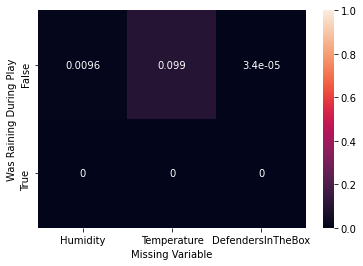

In [21]:
heat = sns.heatmap(missingness_probs(mcar_test_frame,'hasRain'),annot=True,vmin=0.0,vmax=1.0)
heat.set(xlabel='Missing Variable', ylabel='Was Raining During Play')

For thoroughnes's sake, we'll test whether the higher percentage of missing data for temperature occuring when there's no rain is significant. We'll do this through total variation distance, which the function below will find and create a null distribution for. 

In [22]:
def test_missingness_pval(missingCol, dependentCol):
    distr = (
        pd.DataFrame({
                dependentCol: data[dependentCol],
                'is_null': mcar_test_frame[missingCol]
            }).pivot_table(index='is_null', columns=dependentCol, aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
    )
    distr

    #generate null distribution
    n_repetitions = 200

    tvds = []
    for _ in range(n_repetitions):

        # shuffle the column 
        shuffled_col = (
            data[dependentCol]
            .sample(replace=False, frac=1)
            .reset_index(drop=True)
        )

        # put them in a table
        shuffled = (
            pd.DataFrame({
                dependentCol: shuffled_col,
                'is_null': mcar_test_frame[missingCol]
            })
        )

        # compute the tvd
        shuffled = (
            shuffled
            .pivot_table(index='is_null', columns=dependentCol, aggfunc='size')
            .apply(lambda x:x / x.sum(), axis=1)
        )

        tvd = shuffled.diff().iloc[-1].abs().sum() / 2
        # add it to the list of results

        tvds.append(tvd)

    #use null distribution to calculate p-val
    obs = distr.diff().iloc[-1].abs().sum() / 2
    pval = min(np.mean(tvds > obs),np.mean(tvds < obs))
    pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
    return plt.scatter(obs, 0, color='red', s=40)

We examine the missingness at a significance level of 5% (α = 0.05). The below graph shows the null distribution of TVDs that our observation has a higher p-val than our significance level (p-val>0.05=α), hence we cannot reject the null hypothesis that the missingness we observed is by chance. 

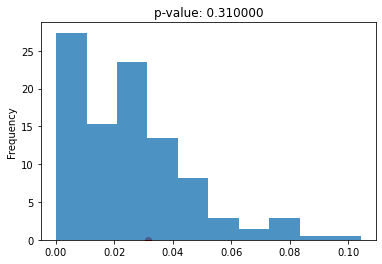

In [23]:
test_missingness_pval('Temperature','hasRain')

Since we do not find significant non-ignorable missingness of values, we can safely use these predictors and simply drop observations with missing values without skewing the data.

In [24]:
#drop rows with any missing values
data = data.dropna()

## Continuation of Data Cleaning
The below function calculates the rusher's average gain per carry over the course of this dataset. This allows us to get a snapshot of how well the rusher usually runs, so that we can account for any skill level differences across players. Our question is more focused on the play-calling and formation of each run, rather than each rusher's individual skill, and we account for that by computing the average yards gained by each rusher. 

In [25]:
def rusherAverageDict(rusherArray, data):
    newDict = {}
    for i in rusherArray:
        newDict[i] = (data[data['NflIdRusher']==i]['Yards'].sum())/(data[data['NflIdRusher']==i]['Yards'].size)
    return newDict

def setRushAv(rushDict,row):
    return rushDict[row["NflIdRusher"]]   

In [26]:
rusher = data['NflIdRusher'].unique()
rusherDict = rusherAverageDict(rusher, data)
data['RusherAverage'] = data.apply(lambda row : setRushAv(rusherDict, row), axis=1)

Another factor we have to take into consideration is when in the game this play occurs. The major factor we are concerned about is fatigue. In the first and third quarters, the players are fresh and able to execute the physical nature of the run plays. This is because they have either just started the game or just came out of halftime. However, in the second, fourth, and overtime quarters, the players have gone a long time without rest and thus will be less able to sustain their blocks and be successful in the run game. 

In [27]:
def is_late_quarter(row):
    if (row == 1) | (row == 3):
         return False
    elif (row == 2) | (row == 4) | (row== 5):
        return True

In [28]:
data['is_late_quarter'] = data.Quarter.apply(is_late_quarter)

## How do we define success?
We experimented with various definitions, including solely by yards gained, but felt that other metrics did not capture the full picture. If it is 3rd and 15, meaning the team has basically one more chance to get 15 yards, and a rusher gets 10 yards, that play was not successful. On the other hand, on a 2nd and 4, a rusher getting 10 yards would be extremely successful. The idea is that not all yardage gains are created equal, and we account for that using the following widely accepted definition of success: These threshholds were deteremined to be where most teams needed to achieve in each play to most likely reach first down again in the book The Hidden Game of Football by Pete Palmer, Bob Carroll, and John Thorn. 
(One of many sources for this information can be found at the Football Outsiders Glossary)
* On first down, the play is successful when it gains at least 45% of the yards to go
* On second down, the play is successful when it gains at least 60% of the yards to go
* On third and fourth down, the play is only successful if it gains all the yards to go


In [29]:
def define_success(row):
    if row['Down'] == 1:
         return (row['Yards'] >= .45*row['Distance'])
    elif row['Down'] == 2:
        return (row['Yards'] >= .6*row['Distance'])
    else:
        return (row['Yards'] >= row['Distance'])
        

In [30]:
data['Success'] = data.apply(define_success, axis=1)

Below we engineer additional features of interest that would more accurately describe the game situation to see if we can see any interesting realationships. These features include how far the offense is from the endzone, the current score differential relative to the offense, and whether or not the offense is the Home team. 

In [31]:
def findYardLine(row):
    if row["PossessionTeam"] != row["FieldPosition"]:
        return 100 - row["YardLine"] 
    else:
        return row["YardLine"]

In [32]:
data['YardLine'] = data.apply(lambda row : findYardLine(row), axis=1)

In [33]:
def findScoreDiff(row):
    sum = row["HomeScoreBeforePlay"] - row["VisitorScoreBeforePlay"]
    if row["PossessionTeam"] == row["HomeTeamAbbr"]:
        return sum
    else:
        return -1*sum

In [34]:
data['ScoreDiff'] = data.apply(lambda row : findScoreDiff(row), axis=1)

In [35]:
#shows whether team is playing a home game or not
data['IsHome'] = data['Team'].apply(lambda row: 1.0 if row=='home' else 0.0)
data = data.drop('Team',axis=1)

In [36]:
data = data.drop(['Quarter', 'GameId', 'NflId', 'HomeTeamAbbr', "VisitorTeamAbbr", "PossessionTeam", "FieldPosition", "HomeScoreBeforePlay", "VisitorScoreBeforePlay"], axis=1)

Since we're going to be using play direction in our regression, we need to convert it to a numerical binary variable

In [37]:
#Convert Play Direction 
data['PlayDirRight'] = data.PlayDirection.apply(lambda x: 1 if x=='right' else 0)

The turf type required some standardizing as some entries included the brand name, whilst other entries were in different cases etc. We'll ordinal encode these values so that they do not overly correlate with each other later on. Since turf is the most common type, it will serve as our base value = 0, whilst hybrid fields = 1 and fully natural grass fields = 2.

In [38]:
#Standardize ground type
def ground_type(row):
    row = row.lower()
    if 'ubu' in row:
        return 0 #'turf'
    elif 'turf' in row:
        return 0 #'turf'
    elif 'sis' in row:
        return 1 #'hybrid'
    elif 'grassmaster' in row:
        return 1 #'hybrid'
    elif 'artificial' in row or 'artifical' in row:
        return 0 #'turf'
    elif 'grass' in row or 'natural' in row:
        return 2#'grass'
    #in case there's missing data or something not caught
    else:
        return row
    
data.Turf = data.Turf.apply(ground_type)

Since our question is in regards to how offense responds to the game situation, we need to create a column of the types of offensive personnel present. We can also use the same method to generate the type of defense present in order to see how any given offense handles any given defense.

In [39]:
#get all unique position abbreviations present in OffensePersonnel
uniqueOffPersonnelSets = data.OffensePersonnel.str.replace(r'\d','').unique()
splitUnqOffSets = []
for offStr in uniqueOffPersonnelSets:
    splitUnqOffSets.append(set(offStr.replace(' ','').split(',')))
uniqueOffPosAbbrs=set.union(*splitUnqOffSets)

In [40]:
#Extract number of different types of Offensive Personnel
for abbr in uniqueOffPosAbbrs:
    data['Off_'+abbr] = data.OffensePersonnel.str.extract(r'(\d (?={}))'.format(abbr))

In [41]:
#get all unique position abbreviations present in DefensePersonnel
uniqueDefPersonnelSets = data.DefensePersonnel.str.replace(r'\d','').unique()
splitUnqDefSets = []
for defstr in uniqueDefPersonnelSets:
    splitUnqDefSets.append(set(defstr.replace(' ','').split(',')))
uniqueDefPosAbbrs = set.union(*splitUnqDefSets)

In [42]:
#Extract number of different types of Defensive Personnel
for abbr in uniqueDefPosAbbrs:
    data['Def_'+abbr] = data.DefensePersonnel.str.extract(r'(\d (?={}))'.format(abbr))

In [43]:
#Turn nan values from extracting position numbers into 0
posAbbrs = list(map(lambda x: 'Off_'+x,uniqueOffPosAbbrs))+list(map(lambda x: 'Def_'+x,uniqueDefPosAbbrs))
fill_p_abbr_dct = dict(zip(posAbbrs,np.zeros(len(posAbbrs),dtype=int)))
data = data.fillna(value=fill_p_abbr_dct)

The offense play type is defined by the number of running backs, tight ends, wide receivers, and offensive linemen. Some common examples can be seen in this image sourced from https://www.insidethe49.com/football-101/offensive-personnel-packages-nfl/.

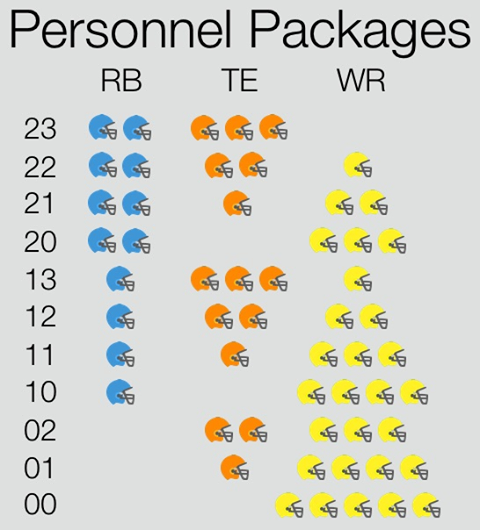

In [44]:
Image(filename = "personnel_packages.png", width=400, height=400)

In [45]:
#In addition to just the RB TE and WR position counts seen in the image, 
#the number of Offensive linemen determines whether the formation is "heavy"
def gen_off_type(row):
    rb = str(row['Off_RB']).strip()
    te = str(row['Off_TE']).strip()
    wr = str(row['Off_WR']).strip()
    ol = int(row['Off_OL'])
    
    if ol>5:
        return rb+te+' heavy'
    else:
        return rb+te
    
data['Off_play_type'] = data.apply(gen_off_type,axis=1)

In [46]:
def gen_def_type(def_db):
    def_db = int(def_db)
    if def_db<4:
        return 'big'
    elif def_db==4:
        return 'base'
    elif def_db==5:
        return 'nickel'
    elif def_db>=6:
        return 'dime'
    
#Since defense formation is a categroical variable 
#but also a predictor we need in our regression, we need to OHE it
data = data.join(pd.get_dummies(data.Def_DB.apply(gen_def_type)))

Since this data is OHE'd, they'd have perfect multicollinearity in our regression unless we drop one of them. Hence, we find the most common defense type and use it as our base, dropping that column from our regression

In [47]:
defense_type_counts = data[['base','big','dime','nickel']].sum().sort_values(ascending=False)
defense_type_counts

nickel    13039
base      11279
dime       1491
big         680
dtype: int64

In [48]:
#Since nickel is the most common one, we'll drop that column and use it as a base condition
data = data.drop('nickel',axis=1)

Now we can drop the columns we used for standardization and feature engineering, then cast boolean values to ints so our libraries have an easier time accepting the data.

In [49]:
data = data.drop(['NflIdRusher','DisplayName','GameClock','OffensePersonnel','Yards',
           'DefensePersonnel','GameWeather','PlayDirection','PlayerWeight']+list(fill_p_abbr_dct.keys()),axis=1)
data= data.set_index('PlayId')
data = data.astype({'is_late_quarter':int,'Success':int,'hasRain':int,'Humidity':int})

In [50]:
#Seperate our data into independent predictors and dependent variable
data_X = data.drop(['Success'],axis=1)
data_y = data['Success']

In [51]:
#turn our season column ordinal
data_X['Season'] = data_X['Season'].apply(lambda x: x-2017)

Our data wrangling is now mostly finished. We should now move on to EDA to see if our data needs any more adjustments

In [52]:
data_X.head()

,Season,YardLine,Down,Distance,DefendersInTheBox,Week,Turf,Temperature,Humidity,OffAvgWeight,DefAvgWeight,hasRain,RusherAverage,is_late_quarter,ScoreDiff,IsHome,PlayDirRight,Off_play_type,base,big,dime
PlayId,,,,,,,,,,,,,,,,,,,,,
20170907000118,0,35,3,2,6.0,1,0,63.0,77,259.181818,233.545455,0,4.129412,0,0,1.0,0,11,0,0,1
20170907000139,0,43,1,10,6.0,1,0,63.0,77,259.181818,233.545455,0,4.129412,0,0,1.0,0,11,0,0,1
20170907000189,0,65,1,10,7.0,1,0,63.0,77,259.181818,233.545455,0,4.129412,0,0,1.0,0,11,0,0,1
20170907000345,0,98,2,2,9.0,1,0,63.0,77,282.545455,257.454545,0,3.560345,0,0,1.0,0,22 heavy,0,1,0
20170907000395,0,25,1,10,7.0,1,0,63.0,77,268.454545,242.454545,0,4.700000,0,-7,0.0,1,13,0,0,1


# EDA
Now that most of our preprocessing is complete, let's take a closer look at the data we have at hand. 

### Observations per Offensive Formation
Since we're investigating how any given offensive formation does in any given game situation, we must first make sure that we have enough observations for every offensive formation in the dataset to carry out meaningful analysis. The barplot below shows how many times each formation is used in our dataset. 

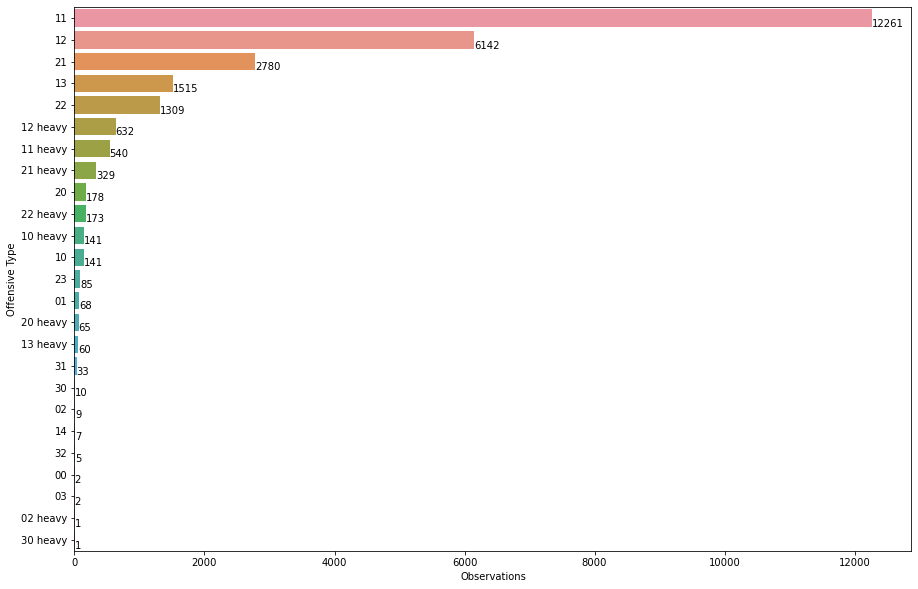

In [53]:
fig, ax = plt.subplots(figsize=(15,10))
bar_plot_off_plays = data_X.Off_play_type.value_counts()
(
    sns.barplot(y=bar_plot_off_plays.index,
                x=bar_plot_off_plays,ax=ax)
    .set(xlabel='Observations', ylabel='Offensive Type')
)
for b in ax.patches:
    x_pos = b.get_x() + b.get_width() + 0.75
    y_pos = b.get_y() + b.get_height()
    value = int(b.get_width())
    ax.text(x_pos, y_pos, value, ha="left")

Interestingly, We see that the distribution of offensive formations seems to follow a relatively zipfian distribution. This however means that we may not be able to carry out meaningful statistical inferences and analysis on the rarer play types such as "30 heavy" or "02 heavy". As a general rule of thumb, the central limit theorem requires a sample size ≥30 most of the time, hence we can only carry out a regression on any offensive formation with more than 30 observations. 

In [54]:
#gets list of plays with over 30 observations
counts_per_play = data_X.Off_play_type.value_counts()
valid_plays = counts_per_play[counts_per_play>30].index

In [55]:
data_X = data_X[data_X.Off_play_type.isin(valid_plays)]
data_y=  data_y.loc[data_X.index]

### Multicollinearity Check
Since we are going to be interpreting the coefficients of our regression in more detail, we need to check that our predictor variables are not overly correlated, otherwise the coefficients would be overly sensitive to small changes in the data. The below heatmap shows the correlation coefficient between our independent variables. If there are any pair of predictors that are overly correlated, we would need to only keep one in order to accurately analyze our coefficients. This may also give us interesting insights into our data. 

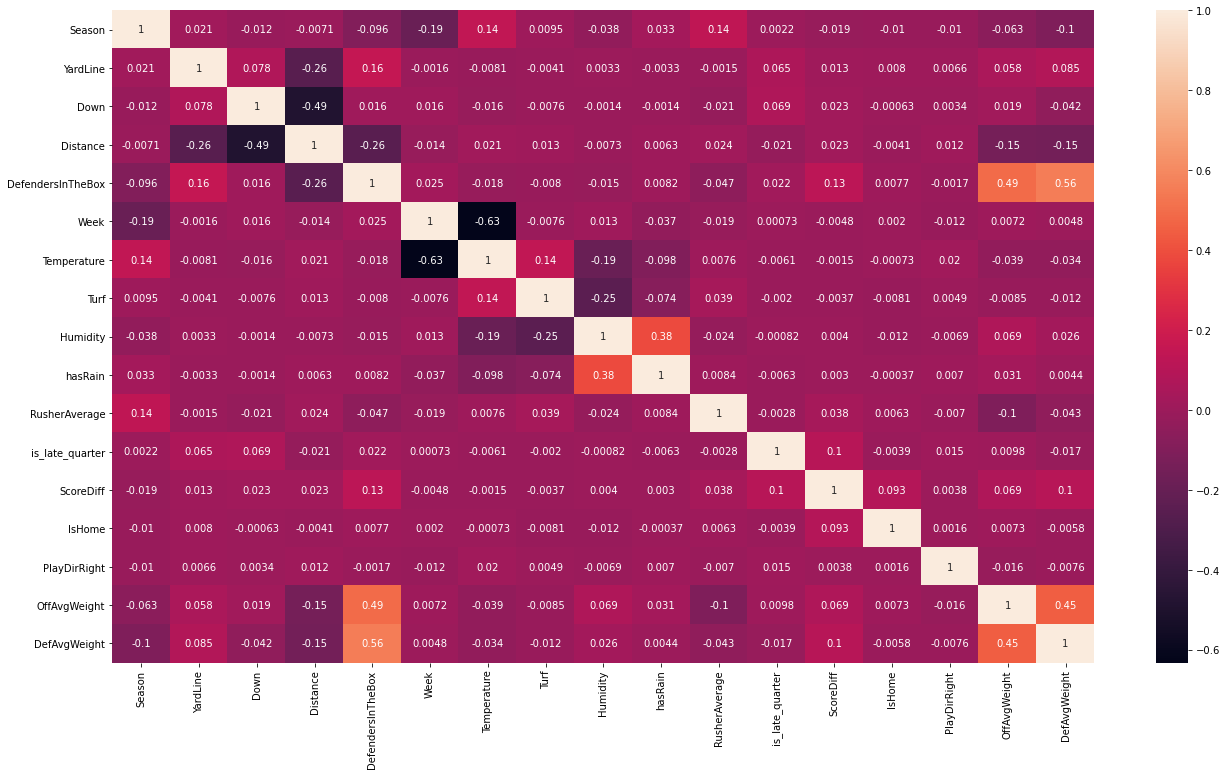

In [56]:
fig, ax = plt.subplots(figsize=(22,12)) 
heat = sns.heatmap(data_X[['Season', 'YardLine', 'Down', 'Distance', 'DefendersInTheBox', 'Week',
       'Temperature', 'Turf','Humidity', 'hasRain', 'RusherAverage',
       'is_late_quarter', 'ScoreDiff', 'IsHome','PlayDirRight','OffAvgWeight','DefAvgWeight']].corr(),annot=True,ax=ax)

#### Notable correlations
- **Down & Distance**:  
It seems like down and distance have a very high negative correlation. This is likely because the distance variable defines the yards the team needs to advance the ball in order to reach the next first down. Since you are likely advancing the ball after each down, which shortens the distance, distance and down would have a high correlation. 

- **Week & Temperature**:
Since NFL seasons start during summer and end during winter, the number of weeks into the season is negatively correlated with temperature.

- **hasRain & Humidity**
Obviously the amount of humidity would be slightly positively correlated with whether there's rain or not. Though the correlation is relatively small, it may be that the weather variables such as rain humidity and temperature are multicollinear in combination (low temperature and high humidity combined would correlate with rain). We will keep this in mind when we analyze the dataset via variance inflation factor.

- **Distance & DefendersInTheBox**
The negative correlation suggests that the opposing team tends to put more defenders in the box as the offensive team gets closer to a first down. 

- **Yardline & Distance**
The negative correlation here suggests that as starting line increases, the distance needed for a first down decreases or vice versa. This is likely because as the the ball moves forward, you're closing the distance needed for a first down.



- **DefendersInTheBox & Average weights**
The positive correlation between the average weights suggests that when defense or offense puts on bigger and heavier players, the opposing side responds in kind. Furthermore, the positive correlation between DefendersInTheBox and the average weights suggests that defenders who are in the box tend to be heavier and bigger players. Likewise, when there are more defenders in the box, the offense is likely putting in heavier players to deal with the increased defense as well. 

Since none of the aforementioned correlations exceed 0.75, we do not have to take any specific action. The rest of the high correlations are caused by our one-hot-encoded values being correlated with their same category, and could therefore be safely ignored.

However, we need to ensure that any combination of columns does not overly correlate with any other column. For example, though rain and humidity and temperature all do not have an overly high correlation in pairs, the combination of low temperature and high humidity might correlate with rain. 

To check this, we'll use the variance inflation factor. In essence, a higher VIF for a variable means that it is likely to be a collinear with a combination of the other variables. VIFs take a minimum possible value of 1 when no collinearity happens at all. As a rule of thumb, when VIF exceeds 5, the predictors would be overly collinear and we might have to take action.

As we can see below, there are multiple predictors that have a VIF value way exceeding 5. This means that the standard deviations and by extension p-value significance of our estimators in the regression would be misleading. This is actually near inevitable since we have so many predictors, meaning it is much easier create a correlation via linear combination. Since we're going to be interpreting the coefficients, we will have to make some adjustments

In [57]:
no_play_data = data_X.drop(['Off_play_type'],axis=1)

vifs= []
for i in range(len(no_play_data.columns)):
    vifs.append(variance_inflation_factor(no_play_data.values,i))
pd.DataFrame({'VIF':vifs}).set_index([no_play_data.columns])

,VIF
Season,2.414804
YardLine,5.611965
Down,8.250870
Distance,8.633919
DefendersInTheBox,102.442645
Week,7.051155
Turf,2.817700
Temperature,24.598155
Humidity,13.186534
OffAvgWeight,1614.354700


To solve this multicollinearity problem, we will use PCA to gain principal components of predictor variables with VIF>5. We will perform PCA separately on two closely correlated groups. This way there may still be some multicollinearity, but it would likely be easier to interpret our coefficients compared to if we performed PCA all together. Our coefficients will, nonetheless, still suffer some interpretability issues, but as a whole PCA would allow us to more accurately gauge whether our predictors are significant or not later on in the regression. To do this, however, we need to first standardize the data.

#### PCA: Temperature, Humidity, Week
As we saw in the correlation matrix, temperature, humidity, and week all seem to be correlated, which as we noted before made sense since as the year drew closer to winter temperature and humidity would change accordingly. Furthermore, Temperature and humidity likely influence each other as well. Hence, we'll perform PCA on these predictors together. 

In [58]:
#temperature
thw_pca_data = data_X[['Temperature','Humidity','Week']]
thw_pca_columns = ['Temperature','Humidity','Week']
thw_pca_data = StandardScaler().fit_transform(thw_pca_data)

In [59]:
thw_pca = PCA(n_components=thw_pca_data.shape[1])
thw_pca_fit = thw_pca.fit(thw_pca_data)
thw_pca_components = thw_pca.fit_transform(thw_pca_data)

In [60]:
thw_load_matrix = pd.DataFrame(thw_pca.components_.T, 
                                  columns=['pc'+str(i) for i in range(1,thw_pca_data.shape[1]+1)], 
                                  index=thw_pca_columns)

In [61]:
pc_names = []

This first component seems to mainly reduce the effect of dropping temperatures as the season drew closer to winter into one variable, hence we'll name it coldWeek.

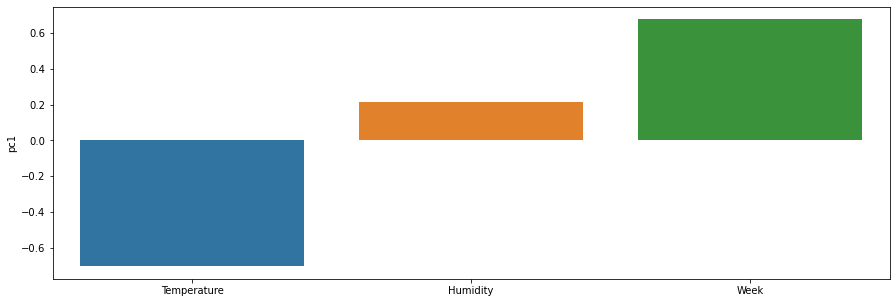

In [62]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x=thw_load_matrix.pc1.index,y=thw_load_matrix.pc1,ax=ax)
pc_names.append('coldWeek')

The second component seems to mainly model the effect of humidity, and contains some loading on week in order to stay orthogonal, hence we'll name it humidity.

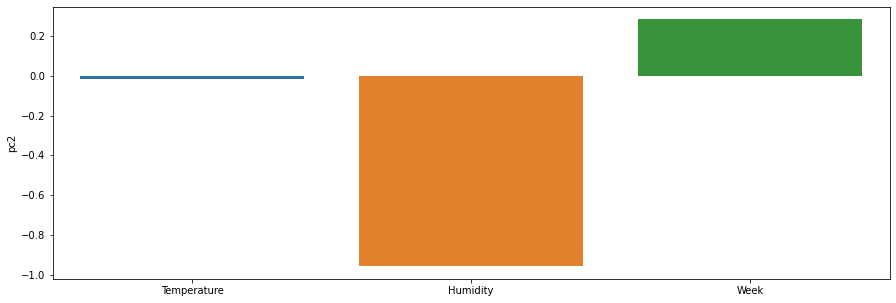

In [63]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x=thw_load_matrix.pc1.index,y=thw_load_matrix.pc2,ax=ax)
pc_names.append('Humidity')

The last component seems to mainly model the effect of increased temperature as week progressed. This is therefore likely the true of effect of abnormal temperature, as week is supposed to be inversely correlated with temperature. We'll therefore name this component temperature.

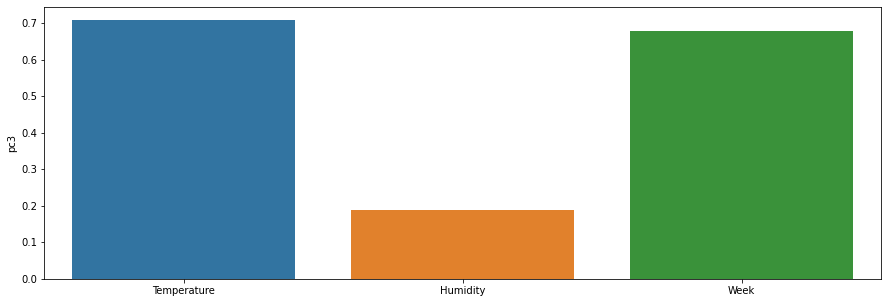

In [64]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x=thw_load_matrix.pc1.index,y=thw_load_matrix.pc3,ax=ax)
pc_names.append('Temperature')

In [65]:
thw_components_df = pd.DataFrame(thw_pca_components,
                                   columns=pc_names
                                  ).set_index(data_X.index)

This graph below shows how much variance in our data is explained by each component. Essentially, it shows how well each component explains our data. Since the components are all relatively interpretable and there are no significant elbows in the below graph, we'll elect to use all these components in the regression.

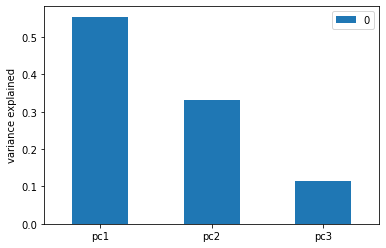

In [66]:
var_exp = pd.DataFrame(thw_pca_fit.explained_variance_ratio_,
                       ['pc'+str(i) for i in range(1,thw_pca_data.shape[1]+1)])
var_exp.plot.bar(rot=0)
plt.ylabel('variance explained');

#### PCA: Distance, Weights, Players
As we saw in the correlation matrix, the variables that deal with distance such as Yardline, down, distance and the variables that are affected by the weights of players are all correlated. We will perform PCA separately on these predictors so that we do not have to combine their effects with time and temperature, and limit the loss in interpretability. 

In [67]:
#weights
dwp_pca_data = data_X[['YardLine','Down','Distance','DefendersInTheBox','OffAvgWeight','DefAvgWeight','RusherAverage']]
dwp_pca_columns = ['YardLine','Down','Distance','DefendersInTheBox','OffAvgWeight','DefAvgWeight','RusherAverage']
dwp_pca_data = StandardScaler().fit_transform(dwp_pca_data)

In [68]:
dwp_pca = PCA(n_components=dwp_pca_data.shape[1])
dwp_pca_fit = dwp_pca.fit(dwp_pca_data)
dwp_pca_components = dwp_pca.fit_transform(dwp_pca_data)

In [69]:
dwp_load_matrix = pd.DataFrame(dwp_pca.components_.T, 
                                  columns=['pc'+str(i) for i in range(1,dwp_pca_data.shape[1]+1)], 
                                  index=dwp_pca_columns)

Again, this graph below shows how much variance in our data is explained by each component. Here we see that there's an elbow between pc2 and pc3, and pc4 and pc5. We'll keep this in mind for now.

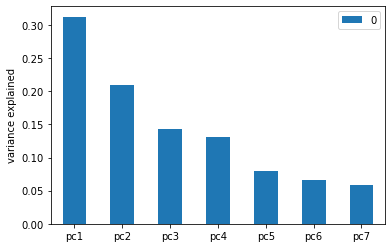

In [70]:
var_exp = pd.DataFrame(dwp_pca_fit.explained_variance_ratio_,
                       ['pc'+str(i) for i in range(1,dwp_pca_data.shape[1]+1)])
var_exp.plot.bar(rot=0)
plt.ylabel('variance explained');

We will now check the loading of each component on our predictor variables to see what each principal component represents. We will then give each principal component a more meaningful name if possible to aid in interpretability. 

In [71]:
dwp_pc_names = []

It seems like the first component models the effect of the bigger players coming up when the offense is close to getting another first down, due to the high loading on the average weights, defenders, yardLine, down, and negative loading on distance and rusher average. This implies that when the offense is closer to a first down (implying smaller distances) offense pulls out bigger players for a heavier push, and since bigger players are normally slower, rusher average suffers too. Meanwhile, defenders also put bigger players and more people in the box to contest push. We will therefore name this component HeavyCloseFirstDown.

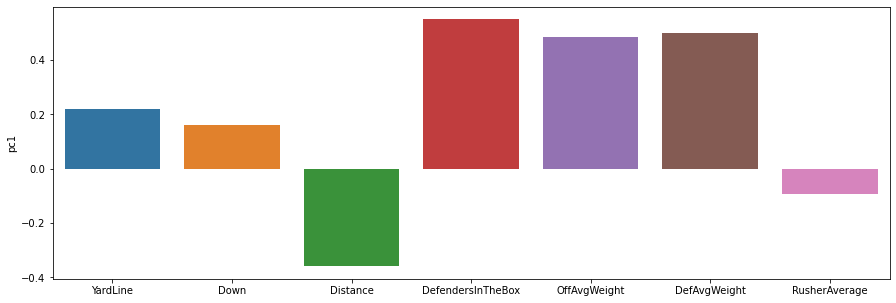

In [72]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x=dwp_load_matrix.pc1.index,y=dwp_load_matrix.pc1,ax=ax)
dwp_pc_names.append('HeavyCloseFirstDown')

This second component seems to model the effect of still having a lot of distance from first down despite already using several downs, as there is high negative loading on down and high positive loading on distance. However, since distance is so closely correlated with defenders and weights, there is some loading on the weights predictors as well. We'll name this component FarFromDown for now. 

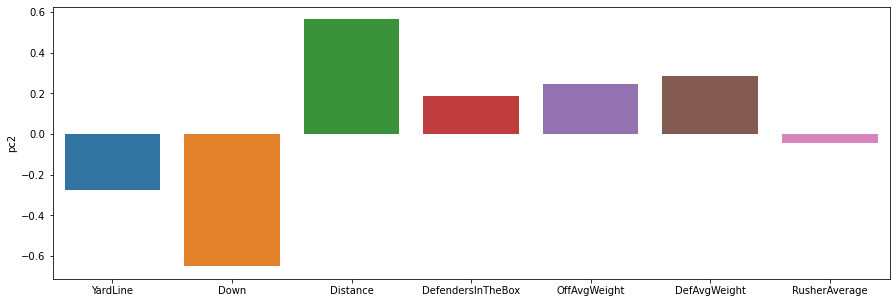

In [73]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x=dwp_load_matrix.pc1.index,y=dwp_load_matrix.pc2,ax=ax)
dwp_pc_names.append('FarFromDown')

This component seems to model the effect of the speed of the player carrying the ball. There is some loading on Yardline and down as most teams probably field there faster players when there's a lot of gorund to cover, and hence there is some overlap that cannot be separated. Nonetheless, since rusher average is the average number of yards the player carries the ball forward in the play, we can call this variable rusher's skill. 

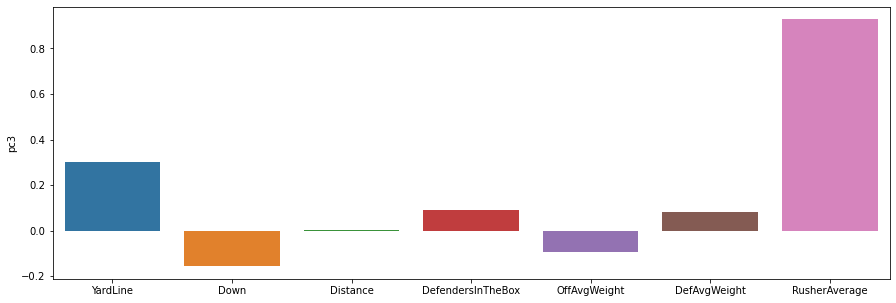

In [74]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x=dwp_load_matrix.pc1.index,y=dwp_load_matrix.pc3,ax=ax)
dwp_pc_names.append('RusherSkill')

This fourth component mainly models the effect of Yardline, but has some loading on RusherAverage and Down to maintain orthogonality. We'll name this Yardline for now. 

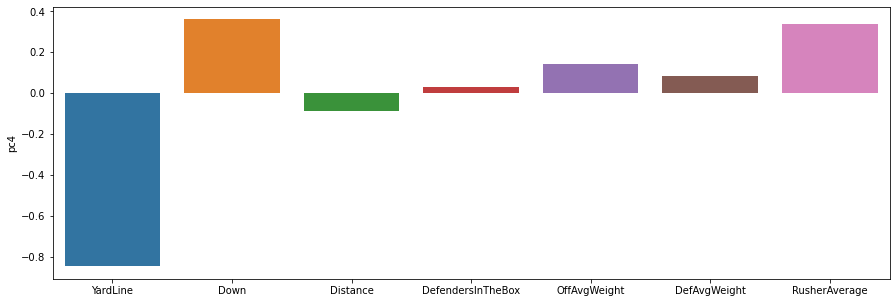

In [75]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x=dwp_load_matrix.pc1.index,y=dwp_load_matrix.pc4,ax=ax)
dwp_pc_names.append('YardLine')

Since the components after the elbow between pc4 and pc5 onwardsd (here we see component 6 as an example) becomes too difficult to interpret, we'll just use the aforementioned components in our regression for now. 

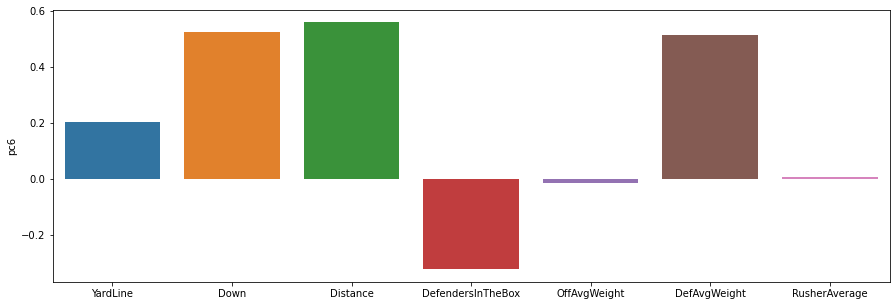

In [76]:
fig, ax = plt.subplots(figsize=(15,5)) 
sns.barplot(x=dwp_load_matrix.pc1.index,y=dwp_load_matrix.pc6,ax=ax)

In [77]:
dwp_components_df = pd.DataFrame(dwp_pca_components,
                                   columns=dwp_pc_names+['pc5','pc6','pc7']
                                  ).set_index(data_X.index)
dwp_components_df = dwp_components_df.drop(['pc5','pc6','pc7'],axis=1)

A second VIF test on the new principal component shows that despite performing PCA seperately, our VIF values are all acceptable. 

In [78]:
data_pca_X = data_X.drop(thw_pca_columns+dwp_pca_columns,axis=1).join(thw_components_df).join(dwp_components_df)
data_vif = data_pca_X.drop('Off_play_type',axis=1)
vifs= []
for i in range(len(data_vif.columns)):
    vifs.append(variance_inflation_factor(data_vif.values,i))
pd.DataFrame({'VIF':vifs}).set_index([data_vif.columns])

,VIF
Season,2.026397
Turf,2.314270
hasRain,1.266172
is_late_quarter,1.812407
ScoreDiff,1.046279
IsHome,1.766320
PlayDirRight,1.778324
base,3.002290
big,1.828883
dime,1.220361


In [79]:
specific = data_pca_X[data_pca_X.Off_play_type == '13']
data_vif = specific.drop('Off_play_type',axis=1)
vifs= []
for i in range(len(data_vif.columns)):
    vifs.append(variance_inflation_factor(data_vif.values,i))
pd.DataFrame({'VIF':vifs}).set_index([data_vif.columns])

,VIF
Season,1.940775
Turf,2.767654
hasRain,1.378614
is_late_quarter,2.301135
ScoreDiff,1.213854
IsHome,2.087397
PlayDirRight,1.890866
base,7.778420
big,2.772098
dime,1.065028


#### Imbalanced Data

We now need to check whether certain variables are overly imbalanced. If they are, we may have variables that do not take a value. Our dependent variable is a binary variable of whether the play succeeded or not, and hence takes a 
Bernouilli distribution. We see below that the distribution isn't heavily skewed towards either success or failure, meaning we can safely run our regression on the variable success.

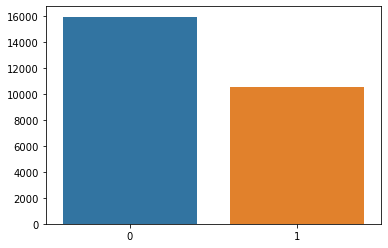

In [80]:
sns.barplot(data_y.value_counts().index,data_y.value_counts().values)

We have a problem, however, with some of our OHE variables. Variables like defensive formation personnel's 'big' and 'dime'. 

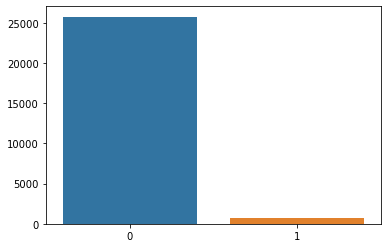

In [81]:
sns.barplot(data_X.big.value_counts().index,data_X.big.value_counts().values)

If we were to groupby different plays, many of the different plays simply don't have any observations against certain defense packages. For example, '12 heavy' has no observations against 'dime', since it is well known that is a very bad matchup. Since so many of these OHE variables are missing, we regrettably would have to drop these defense package variables, otherwise we would be unable to use our regression.

In [82]:
twelve_heavy = data_X[data_X.Off_play_type=='12 heavy']

#shows twelve_heavy rows that have played against dime is an empty dataframe
twelve_heavy[twelve_heavy.dime==1]

,Season,YardLine,Down,Distance,DefendersInTheBox,Week,Turf,Temperature,Humidity,OffAvgWeight,DefAvgWeight,hasRain,RusherAverage,is_late_quarter,ScoreDiff,IsHome,PlayDirRight,Off_play_type,base,big,dime
PlayId,,,,,,,,,,,,,,,,,,,,,


## Regression

We now regress success on all our predictors via logit regression. We chose to use logit regression because success is a binary variable that is better modeled by logit than linear OLS. We will then compare the significance and magnitude of the coefficients between the plays to see how each game variable affects the success rate of our plays. 

In [83]:
from statsmodels.tools.tools import add_constant

In [84]:
#drop defense variables
data_pca_X = data_pca_X.drop(['base','big','dime'],axis=1)

In [85]:
#Create models for each type of play with over 30 observations
all_models = []
for play_type in valid_plays:
    play_specific_X = data_pca_X[data_pca_X.Off_play_type == play_type].drop('Off_play_type',axis=1)
    play_specific_X = add_constant(play_specific_X)
    play_specific_y = data_y.loc[play_specific_X.index]
    mod = Logit(play_specific_y, 
                play_specific_X.astype(float))
    all_models.append(mod)

In [86]:
#create a dictionary of models for easy access
model_dcts = dict(zip(valid_plays,all_models))

In [87]:
#fit each model
results = []
for i in model_dcts:
    results.append(model_dcts[i].fit());

Optimization terminated successfully.
         Current function value: 0.651067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638869
  

In [88]:
#create dictionary of results for easy access
result_dcts = dict(zip(valid_plays,results))

# Data Analysis & Results

Below is an example of our regression results that includes the p-val and coefficient of every variable in the logit regression, along with other statistics. We will use these summaries for our analysis

In [89]:
result_dcts['11'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Success   No. Observations:                12261
Model:                          Logit   Df Residuals:                    12246
Method:                           MLE   Df Model:                           14
Date:                Fri, 19 Feb 2021   Pseudo R-squ.:                 0.04032
Time:                        17:20:12   Log-Likelihood:                -7982.7
converged:                       True   LL-Null:                       -8318.1
Covariance Type:            nonrobust   LLR p-value:                4.435e-134
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3120      0.055     -5.652      0.000      -0.420      -0.204
Season                 -0.0210      0.025     -0.822      0.411      -0.071       0.029
Turf                    0.0172      0.020      0.842      0.400      -0.023       0.057
hasRain                -0.1336      0.084     -1.587      0.113      -0.299       0.031
is_late_quarter         0.0303      0.038      0.798      0.425      -0.044       0.105
ScoreDiff              -0.0068      0.002     -3.888      0.000      -0.010      -0.003
IsHome                  0.0303      0.038      0.799      0.424      -0.044       0.105
PlayDirRight           -0.0113      0.038     -0.301      0.764      -0.085       0.063
coldWeek                0.0178      0.015      1.185      0.236      -0.012       0.047
Humidity               -0.0232      0.021     -1.083      0.279      -0.065       0.019
Temperature            -0.0365      0.032     -1.136      0.256      -0.099       0.026
HeavyCloseFirstDown     0.1776      0.022      8.041      0.000       0.134       0.221
FarFromDown            -0.2741      0.018    -15.358      0.000      -0.309      -0.239
RusherSkill             0.2462      0.023     10.854      0.000       0.202       0.291
YardLine                0.1389      0.021      6.698      0.000       0.098       0.180
=======================================================================================
"""

For the variables that we found to have significant correlation, we determined the plays that it most positively and negatively impacted in our dataset. We also split our offensive personnel packages into three subsections: heavy formations, non-heavy  formations with a low number of running backs, and non-heavy formations with a high number of running backs. This way we were able to also see how each play was affected by the variables within these similar plays. For section, we picked out the significant variables and showed the formation that was most effected along with its coefficient from regression. 

**For low number of running backs**  
HCFD: 11 personnel ( .1784) is the best short yardage situation  
FFD: 10 personnel ( -.39) is by far the worst in long yardage situation  
RS: 11 personnel ( .24) is the best if you have a good rusher  
YL: 13 personnel ( .13) is the best the closer you get to the end zone  
SD: 12 personnel (-.0075 ) is the best to run while you’re ahead  
CW: 01 personnel (-1.09) is by far the worst to run in the cold  
ILQ: 10 personnel (-.76) is the worst to run in late quarter  

**For higher number of running backs**  
HCFD: 21 personnel, (0.0941), is the best in short yardage situation  
FFD: 20 personnel, (-0.5715), is the worst in Long yardage situation  
YL: 22 personnel, (0.1358), the best the closer you get to the end zone  
ILQ: 22 personnel, (-0.6504) is the worst to run in late quarter  
RS: 20 personnel, (0.4699) is the best to run when you have a good rusher  

**For heavy personnel**  
RAIN: 12 heavy personnel (.7354) is by far the best in the rain  
FFD: 11 heavy personnel ( -.5997) is the worst in long yardage situation  
PDR: 11 heavy personnel (.4465) is the best when running right  
PDL: 12 heavy personnel (-.1806) is the best when running left  
TEMP: 22 heavy personnel (.7466) generally run when the temperature is above average  
RS:  10 heavy personnel (.8992) is by far the best when the team has a good rusher  
ILQ: 10 heavy personnel (1.0351) is by far the best in late quarter  

By comparing these coefficients in our regressions, we found some general trends. We found that 11 in general tended to be the most successful formation overall, having positive correlations with many of our predictors. This data therefore supports our initial hypothesis that 11 was the overall best "shotgun" approach, and given its prevalence, it seems like many teams have figured this out as well. 

However, when you're close to first down you should instead run a personnel package that is heavy, as it yielded higher successes than 11. Furthermore, if your rusher is really skilled, you should run a 10 heavy as its coefficient is much higher than other formations, meaning it is much more responsive to your rusher's skill. lastly in late game, 10 heavy also beat out 11 with a much higher coefficient. 

# Ethics & Privacy

The data is publically available through a NFL API, then compiled and publically distributed through kaggle for public use. 

As recently as 2018, the NFL decided to release all in game football related statistics and data about the players to the public and to all the teams in the league. In doing so with good intentions, it was meant to help players and coaches determine their points of strength and points of weakness for their team and every other team they will go up against. However, this release of new information could potentially change the nature of the game. Instead of being a game of pure coaching and player skill and reaction, it could soon become a game of who has better data analysts and better data prediction skills. In a game played at such a high level in the NFL, this data could give certain teams a competitive edge that will help them win more games. While this data could drastically improve player recovery and game planning, it could also be used to play the statistics rather than playing the game.

Also, an analysis of player statistics could be used to make decisions about individual players. General managers could take a look at year by year statistics on players and determine whether or not that player should be kept on the team soley on decreasing or increasing performance in their statistics without assessing the statisticless value of a veteran player whose role is to boost morale on a team or mentor and helps young players develop rather than actually playing with the team. In using this data, ethics and privacy must be considered when making decisions about players and gameplans.

# Conclusion & Discussion

The data obtained from the official NFL big data bowl gave data on every player within each play that happened in the games from 2017-2019. From this data, we were able to engineer several other features in order to better describe any game situation. Since we wanted to see how these factors affected different plays, we decided to run a regression of the success rate of these plays on the predictors we had. This way, we were able to see the magnitude of the coefficients of these predictors and see whether or not these predictors were significant in affecting the play. We chose for our target variable to be a definition of success that many professional football analysts use nowadays, which was first defined in a massively influential book "The Hidden Game of Footbal" by Pete Palmer, Bob Carroll, and John Thorn. This definition takes into account how flat yardage does not necessarily translate to game success, and hence includes the distance necessary in different downs as threshholds to define success. Since the data was highly multicollinear, it threatened the significance and consistency of our coefficients if we were to run a regression straightaway. Hence, we used PCA to obtain components and interpreted the loadings of these components to generate new variables that are less collinear. 

We then proceeded to run our regression, and compared the significance, magnitude, and sign of the coefficients between plays to see how each variable may affect any given play differently. By analyzing the p-val of the coefficients, we saw that certian variables had effects only on certain plays, while being insignificant in others. Furthermore, coefficients of variables also changed across plays in both sign and magnitude. In general, we found that 11 tended to be the most successful formation overall, having positive correlations with many of our predictors. This data therefore supports our initial hypothesis that 11 was the overall best "shotgun" approach, and given its prevalence, it seems like many teams have figured this out as well.

A limitation to our analysis is that the new variables we came up with PCA may not strictly adhere to our interpretations. This is because the loadings were not completely on the variables we attributed the meaning to, as some other variables also had loadings to maintain orthogonality. We also had to drop defensive personnel due to missing variables of a certain category. For example, offenses never ran “12 heavy” against “dime” defense, so we were forced to drop the defenses as predictors. Since we had to drop these variables which are likely to have a huge effect onthe success rate of the offense, there is a possibility that we might be suffering from omitted variables bias that would cause our coefficient estimates to be inconsistent. The possibility of omitted variable bias is further supported by the fact that most of our regressions had relatively low pseudo R^2 values, meaning the predicting power of our models was relatively low. Lastly the lower number of observations for certain obscure plays such as 23 also meant that the significance of the coefficients estimated with them may be impacted, causing them to be insignificant when they should have been with larger observations. 



